In [1]:
import numpy as np

# Wipe all outputs from this notebook
from IPython.display import Image, clear_output, display
clear_output(True)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# Inverting a matrix

We are still trying to solve the linear equation
$$
A \mathbf{x} = \mathbf{b}
$$

Which requires us to construct the matrix $A^{-1}$
$$
\mathbf{y} = A^{-1} \mathbf{b}
$$

How would we do this by hand?

Gauss-Jordan elimination: perform a series of operations on both the left and the right hand sides of our equation (changing both $A$ and $\mathbf{b}$), until the left side of the equation is triangular in form. Because Gauss-Jordan elimination consists of a series of row-wise addition and subtraction operations, we can think of the process as writing each row vector in terms of some linear combination of row vectors, making the whole process expressible as a matrix $M$

$$
(M A) \mathbf{x} = M \mathbf{b} \\
U \mathbf{x} = M \mathbf{b} \\
$$
where we have defined the upper-triangular matrix $U \equiv MA$


#### Why do we want triangular matrices?

If we can reduce our matrix $A$ to upper-triangular form, then we can quickly solve for $\mathbf{x}$ using forward substitution. This should take $\sim\mathcal{O(N^2)}$ operations if $A \in \mathbb{R}^{N \times N}$

In [46]:

def solve_tril(a, b):
    """Given a lower triangular matrix, solve using forward subtitution"""
    #a = a.T # make it lower triangular for cleaner notation
    n = a.shape[0]
    x = np.zeros(n)
    for i in range(n):
        x[i] = (b[i] - np.dot(a[i, :i], x[:i])) / a[i, i]
    return x
    
# A random lower triangular matrix
a = np.tril(np.random.random((10, 10)))
b = np.random.random(10)

print(np.linalg.solve(a, b))
print(solve_tril(a, b))
# print(np.allclose(np.linalg.solve(a, b), solve_triu(a)))



[  1.256178    -0.22601985   1.74850476  -2.23335991   1.39943248
 -14.43437326   8.12239101  19.04477232 -25.62179515  -6.59641919]
[  1.256178    -0.22601985   1.74850476  -2.23335991   1.39943248
 -14.43437326   8.12239101  19.04477232 -25.62179515  -6.59641919]


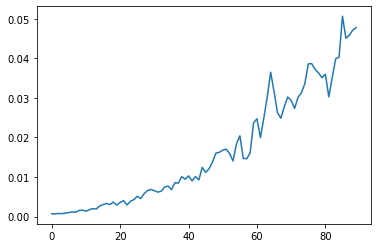

In [38]:
import timeit

all_times = list()
for n in range(10, 100):
    all_reps = [timeit.timeit("solve_tril(np.random.random((n, n)), np.random.random(n))", globals=globals(), number=n) for _ in range(10)]
    all_times.append(np.mean(all_reps))

plt.plot(all_times)

## But how do we reach upper-triangular form?

We know that we want to modify our equation $A \mathbf{x} = \mathbf{b}$ until it has form $U \mathbf{x} = M \mathbf{b}$. We would like to find a straightforward way to perform this reduction, without performing a tedious Gauss-Jordan elimination procedure.

Our key insight is that the matrix $M$ turns out to be a triangular matrix as well. Moreover, because the inverse of a triangular matrix is also a triangular matrix (this can be proven by writing out the matrix multiplication algebra for $U^{-1} U = I$), we therefore can reduce our problem to the reduction

$$
U \mathbf{x} = M \mathbf{b}
$$
defining $M \equiv L^{-1}$, we arrive at the celebrated LU matrix factorization 
$$
L U \mathbf{x} = \mathbf{b}
$$
where $L$ is a lower triangular matrix, and $U$ is an upper triangular matrix.

We can therefore solve for $\mathbf{x}$ by introducing an intermediate variable $\mathbf{h}$, and then $\mathbf{x}$
$$
LU \mathbf{x} = \mathbf{b} \\
L \mathbf{h} = \mathbf{b} \\
$$
where $\mathbf{h} \equiv U \mathbf{x}$. 

Our solution thus consists of the following steps:
1. Solve the equation $\mathbf{h} = L^{-1} \mathbf{b}$. Since $L$ is a triangular matrix, this can be performed using substitution
2. Solve the equation $\mathbf{x} = U^{-1} \mathbf{h}$. Since $U$ is also triangular, this is also fast

## Solving for LU

+ Naive iterative implementation uses Gauss-Jordan elimination
+ A more sophisticated algorithm called Crout's method with pivoting, which performs optimal order of decomposition based on the specific values present in a given row or column
+ Decomposition into L and U is $\sim \mathcal{O}(N^3)$ for an $N \times N$ matrix
+ Given a matrix $A$ and target $\mathbf{b}$, what is the overall runtime to find $\mathbf{x}$?


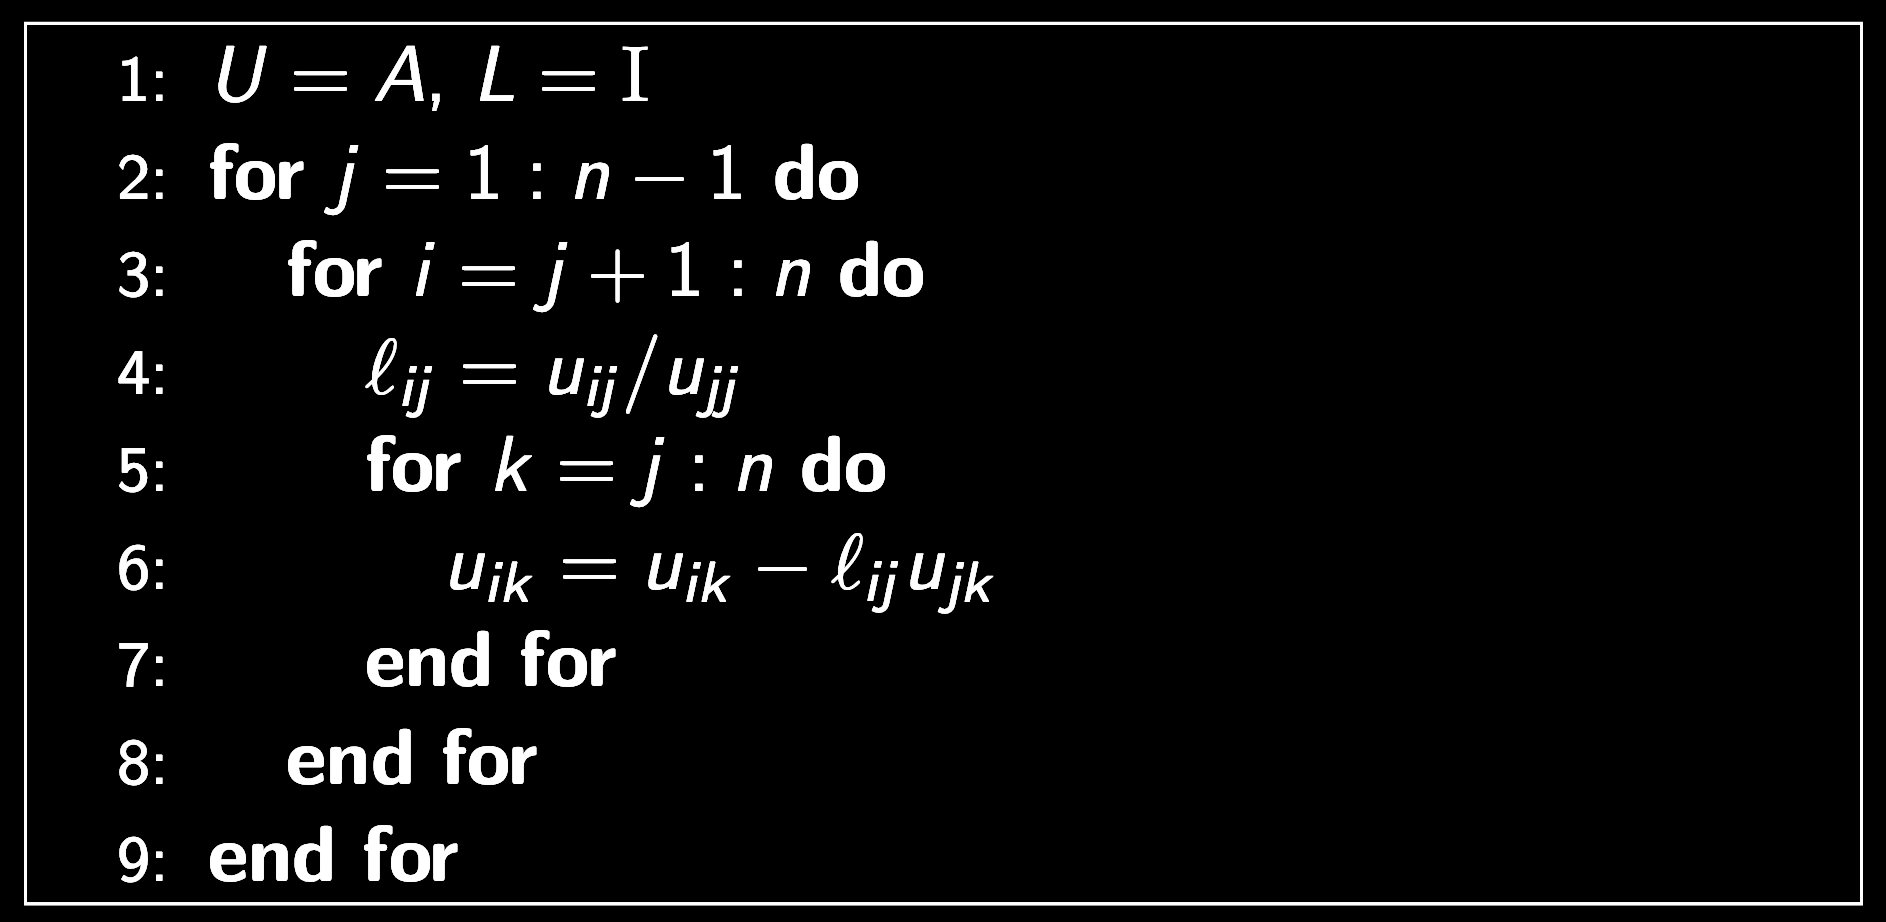

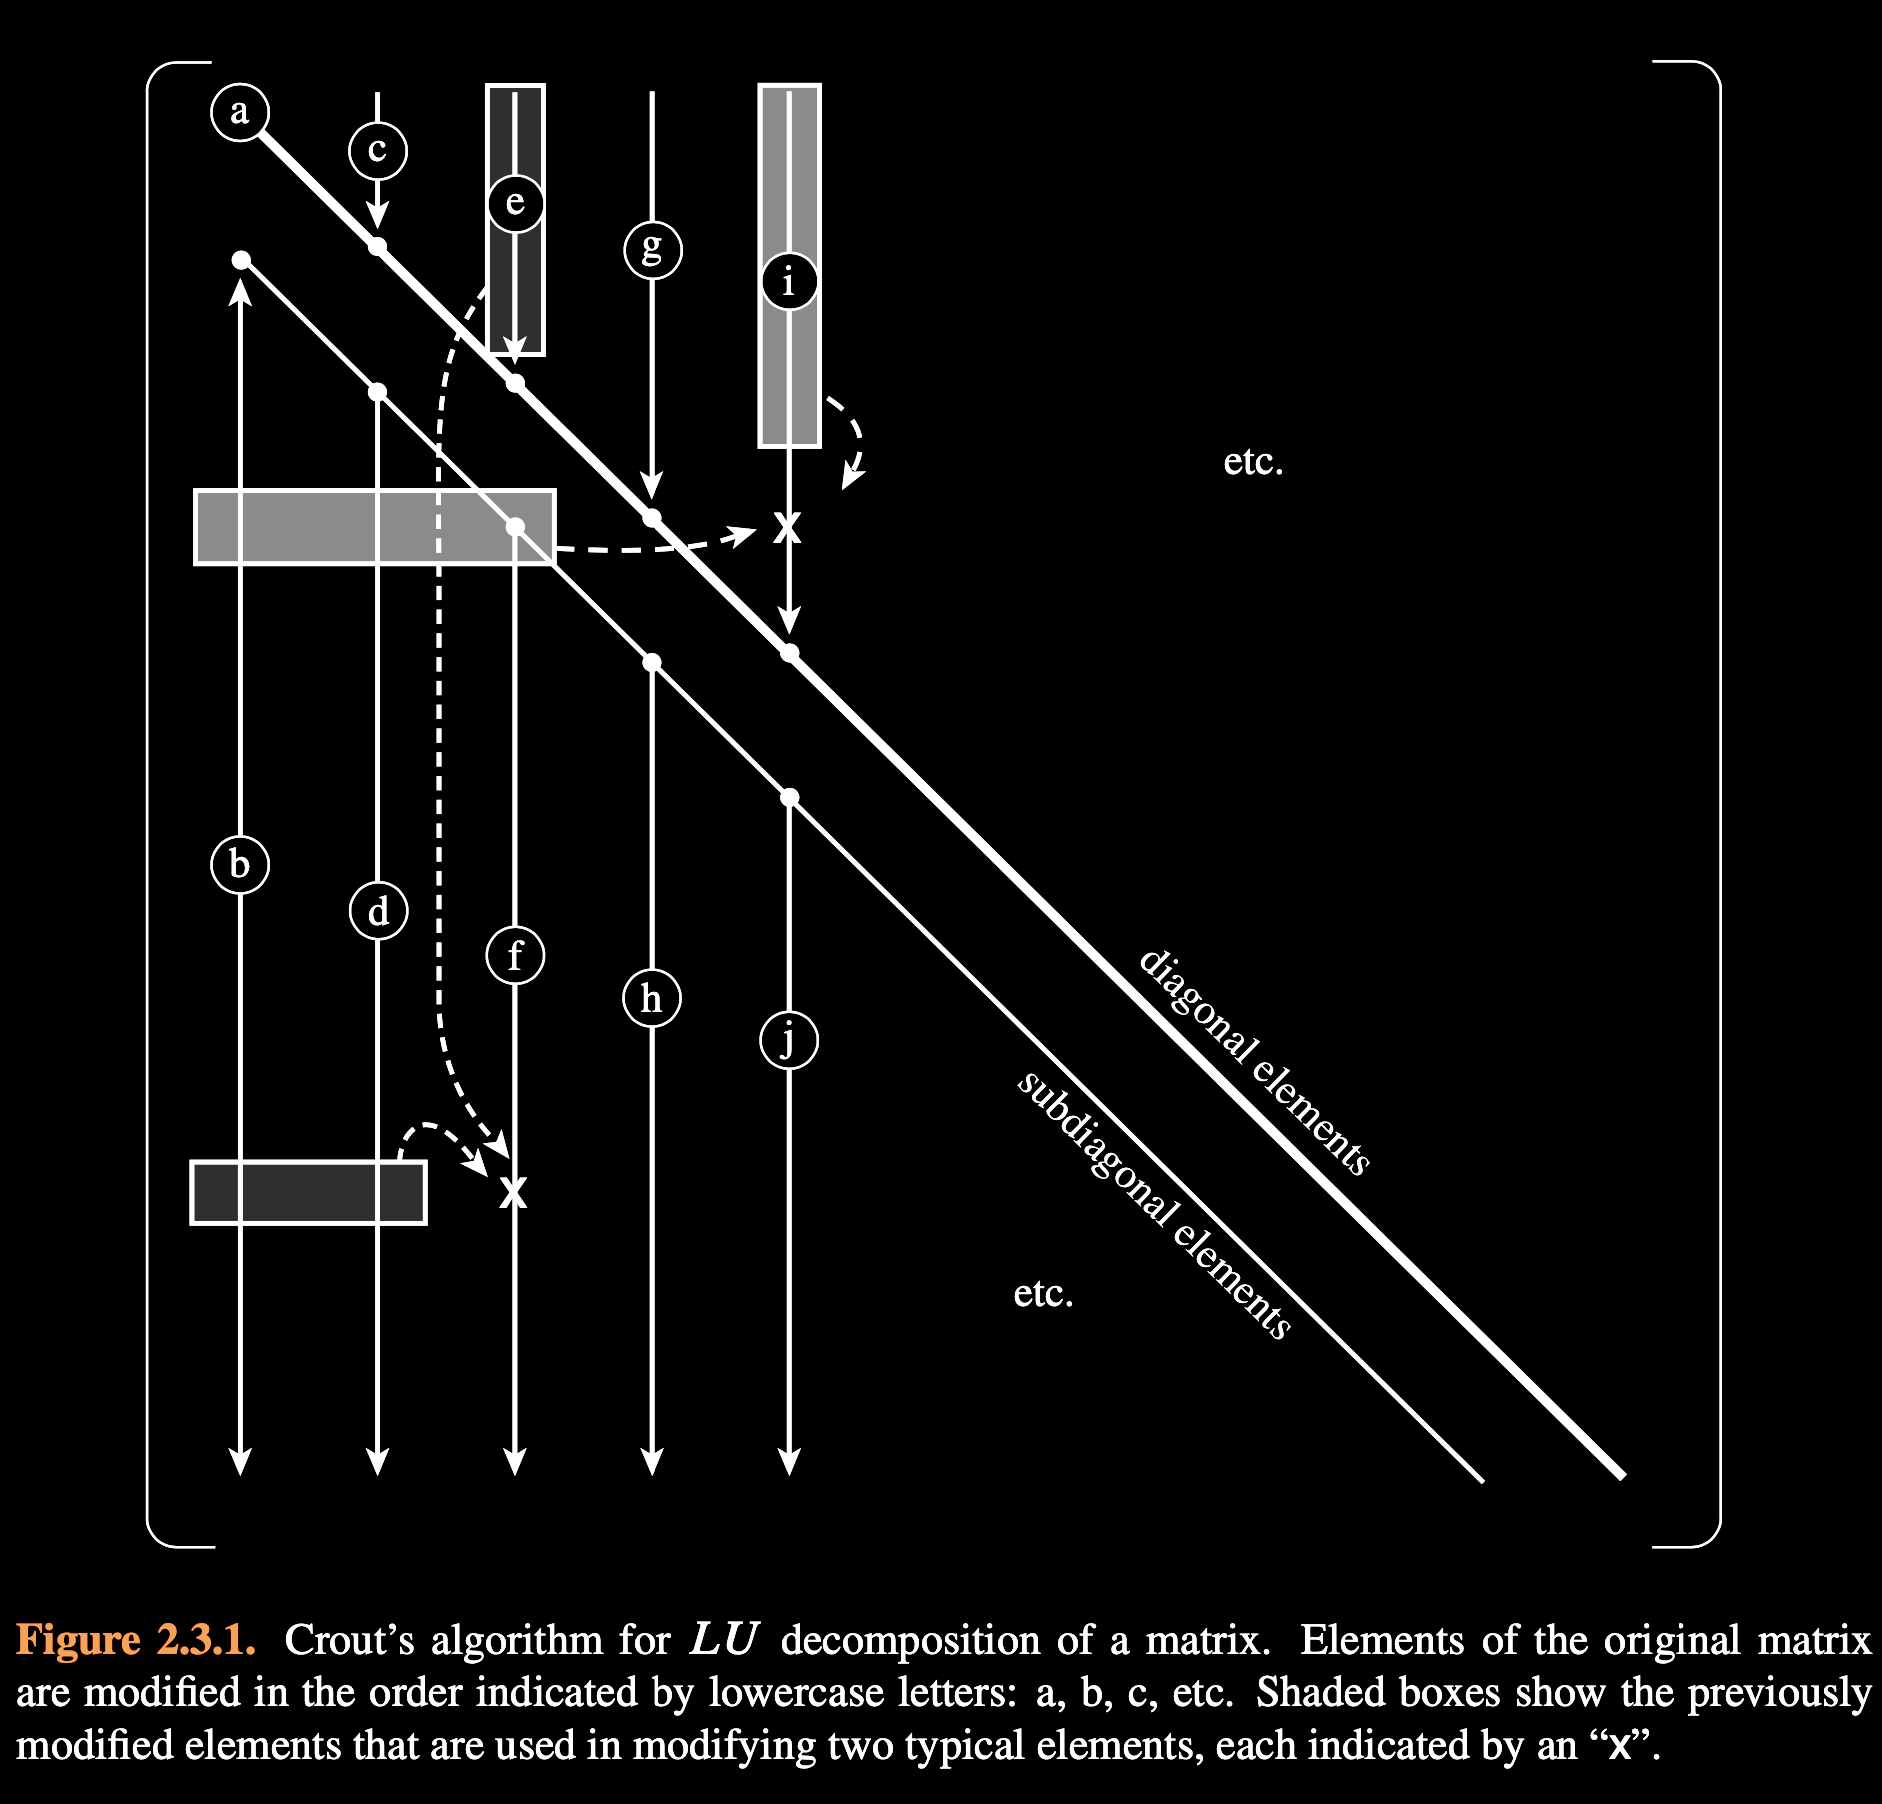

In [45]:

images = [
    Image(filename='../resources/lu_algo.png', width=800), 
    Image(filename='../resources/crout_diagram.png', width=800)
]
## Source: Chris Rycroft's AM205 class
## Source: William Press textbook
display(*images)

In [2]:
class LinearSolver:
    """
    Solve a linear matrix equation via LU decomposition (naive algorithm)
    """
    def __init__(self):
        # Run a small test upon construction
        self.test_lu()


    def test_lu(self):
        """A small test method that the factorization is correct"""
        X = np.random.random((10, 10))
        L, U = self.lu(X)
        assert np.allclose(X, L @ U), "LU decomposition failed"

    def lu(self, a):
        """Perform LU factorization of a matrix"""
        n = a.shape[0]
        L, U = np.identity(n), np.copy(a)
        for i in range(n):
            factor = U[i+1:, i] / U[i, i]
            L[i + 1:, i] = factor
            U[i + 1:] -= factor[:, None] * U[i]
        return L, U

    def forward_substitution(self, L, b):
        """Solve a lower triangular matrix equality of the form Lx = b for x"""
        n = L.shape[0]
        y = np.zeros(n)
        y[0] = b[0] / L[0, 0]
        for i in range(1, n):
            y[i] = (b[i] - np.dot(L[i,:i], y[:i])) / L[i,i]
        return y
        
    def backward_substitution(self, U, b):
        """Solve an upper triangular matrix equality of teh form Ux = b for x"""
        n = U.shape[0]
        y = np.zeros(n)
        y[-1] = b[-1] / U[-1, -1]
        for i in range(n-2, -1, -1):
            y[i] = (b[i] - np.dot(U[i,i+1:], y[i+1:])) / U[i,i]
        return y
        
    def solve(self, X, b):
        L, U = self.lu(X)
        self.L, self.U = L, U

        # Intermediate variable
        h = self.forward_substitution(L, b)
        
        return self.backward_substitution(U, h)
        
        
        
A = np.random.rand(4, 4)
b = np.random.rand(4)

model = LinearSolver()
print(model.solve(A, b))

# Using the numpy built-in solver
print(np.linalg.solve(A, b))



[ 0.52707115  1.09551142 -0.8144515   0.90652132]
[ 0.52707115  1.09551142 -0.8144515   0.90652132]
